<a href="https://colab.research.google.com/github/pachecoleonardo/aprendizaje_no_supervisado/blob/master/02_jerarquico_aglomerativo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> Aplicación de los Métodos de Agrupamiento</h1></center>
<center><h1> Aprendizaje No Supervisado</h1></center>
<center><h1> Agrupamiento por jerárquico : Aglomerativo</h1></center>
<br>

### - Alexandro López González
### - Leonardo Pacheco Garduño
### - Manuel Garcia Sanes
<br>
<br>

En este notebook, realizaremos los siguiente:

- Aplicación del algoritmo aglomerativo  a los dos datasets seleccionados. 

- Evaluación de los resultados utilizando métricas intrínsecas o extrínsecas según sea el caso

- Análisis del resultado
<br>
<br>


## 1. Cargamos las librerias necesarias

In [0]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.cluster.hierarchy import dendrogram


## 2. Cargamos el dataset con agrupamiento conocido

**Nombre:<br>

SEEDS<br>

**Abstract: 

Measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes.<br>

**Atributos (Reales): <br>

area A,<br>
perimeter P,<br>
compactness C = 4piA/P^2,<br>
length of kernel,<br>
width of kernel,<br>
asymmetry coefficient<br>
length of kernel groove. All of these parameters were real-valued continuous.<br>

**Instancias:**<br>

210<br>

URL:<br>
https://archive.ics.uci.edu/ml/datasets/seeds#

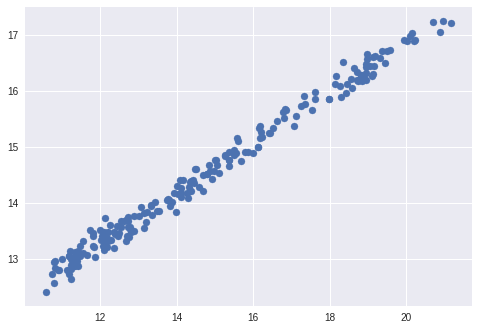

In [3]:
np.random.seed(15) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

#Cargamos los datos
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'

D = np.array(pd.read_csv(data_file_url,delimiter='\s+', header=None))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:-1]
Dy = D[:,-1]

plt.scatter(Dx[:,0], Dx[:,1])
plt.show()


El dataset cargado tiene 210 instancias, 


In [0]:
def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD


Texto


In [0]:
def clustering_aglomerativo(mD, criterio):
    mParticiones = np.zeros(mD.shape[0]**2, dtype = np.int8)
    mParticiones.shape = (mD.shape[0], mD.shape[0])
    mParticiones[:,209] = np.arange(210)

    # Recorremos de manera decreciente 
    # ya que sabemos que el número de uniones es exactamente de n-1

    a = np.array(range(mParticiones.shape[1]-1))
    for n in a[::-1]:
        mParticiones[:,n] = mParticiones[:,n+1]

        clust_actuales = np.unique(mParticiones[:,n])
        mDC = criterio(mD, clust_actuales, mParticiones[:,n])

        ind = np.unravel_index(np.argmin(mDC, axis=None), mDC.shape)
        mParticiones[mParticiones[:,n]==clust_actuales[ind[1]],n] = clust_actuales[ind[0]]

    return mParticiones

Texto

In [0]:
def disimilitud_media(mD, clust_actuales, particion):
    mDC = np.zeros(clust_actuales.size**2)
    mDC.shape = (clust_actuales.size,clust_actuales.size)
    for n1 in np.arange(clust_actuales.size):
        exC1 = np.where(particion==clust_actuales[n1])[0]
        for n2 in np.arange(clust_actuales.size):
            exC2 = np.where(particion==clust_actuales[n2])[0]
            mDC[n1,n2] = np.mean(mD[np.ix_(exC1,exC2)])
    # Rellenamos la matriz diagonal para evitar que se proponga
    # la unión de un clúster consigo mismo
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC

Texto

In [0]:
def disimilitud_maxima(mD, clust_actuales, particion):
    mDC = np.zeros(clust_actuales.size**2)
    mDC.shape = (clust_actuales.size,clust_actuales.size)
    for n1 in np.arange(clust_actuales.size):
        exC1 = np.where(particion==clust_actuales[n1])[0]
        for n2 in np.arange(clust_actuales.size):
            exC2 = np.where(particion==clust_actuales[n2])[0]
            mDC[n1,n2] = np.max(mD[np.ix_(exC1,exC2)])
    # Rellenamos la matriz diagonal para evitar que se proponga
    # la unión de un clúster consigo mismo
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC


Texto

In [0]:
def disimilitud_minima(mD, clust_actuales, particion):
    mDC = np.zeros(clust_actuales.size**2)
    mDC.shape = (clust_actuales.size,clust_actuales.size)
    for n1 in np.arange(clust_actuales.size):
        exC1 = np.where(particion==clust_actuales[n1])[0]
        for n2 in np.arange(clust_actuales.size):
            exC2 = np.where(particion==clust_actuales[n2])[0]
            mDC[n1,n2] = np.min(mD[np.ix_(exC1,exC2)])
    # Rellenamos la matriz diagonal para evitar que se proponga
    # la unión de un clúster consigo mismo
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC


Finalmente, incluimos una serie de funciones que nos van a permitir visualizar los resultados:


In [0]:
# Muestra los ejemplos coloreados según su pertenencia a los clústeres
# K indica el número de clústeres a mostrar a partir de la jerarquía
def plot_particion_K(Dx, mParticiones,K):
    cmap = get_cmap('tab20')
    vals = np.arange(Dx.shape[0]+2)/(Dx.shape[0]+2)
    rgba = cmap(vals[np.arange(Dx.shape[0])+1])

    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(Dx[:,0],Dx[:,1], c=rgba[mParticiones[:,K-1],:])

# Muestra el plot de todas las particiones posibles de la jerarquía
def plot_particiones(Dx, mParticiones):
    for k in np.arange(mParticiones.shape[1]):
        plot_particion_K(Dx, mParticiones,k+1)

# Muestra el dendrograma de la jerarquía
def plot_dendrograma_de_mparticiones(mD, mParticiones):
    nPasos = mD.shape[0]-1
    distancias = np.zeros(nPasos)
    tamanyos = np.zeros(nPasos)
    uniones = np.zeros(2*nPasos,dtype=np.int8)
    uniones.shape=(nPasos,2)

    mNParticiones = mParticiones.copy()
    for n in np.arange(mNParticiones.shape[0]):
        valor = mParticiones[n,mNParticiones.shape[1]-1]
        mNParticiones[mParticiones==valor] = n

    k = 0
    aux = np.array(range(mNParticiones.shape[1]-1))
    for n in aux[::-1]:
        # cual es el diferente?
        prim_diferencia = np.where(mParticiones[:,n]!=mParticiones[:,n+1])[0][0]
        submatriz = mNParticiones[:,:n+1]
        submatriz[submatriz==mNParticiones[prim_diferencia,n]] = mNParticiones.shape[1]+k
        mNParticiones[:,:n+1] = submatriz
        uniones[k,:] = np.unique(mNParticiones[mNParticiones[:,n]==mNParticiones.shape[1]+k,n+1])
        tamanyos[k] = np.sum(mNParticiones[:,n]==mNParticiones.shape[1]+k)

        vs = mNParticiones[:,n+1]
        distancias[k] = 1 / (2 * tamanyos[k]) * (    
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,0])[0],
                              np.where(vs == uniones[k,1])[0])])+
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,1])[0],
                              np.where(vs == uniones[k,0])[0])]))
        k += 1

    distancias = np.arange(uniones.shape[0])
    # Creamos la matriz de enlaces que necesita el método dendrogram de scipy
    mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

    plt.figure(figsize=(25, 10))
    plt.title('Dendrograma de Clustering Jerárquico')
    plt.xlabel('Índice del caso')
    plt.ylabel('Distancia')
    dendrogram(mEnlaces)
    plt.show()



Ahora ya estamos en disposición de realizar el clustering jerárquico aglomerativo. Empezaremos por calcular la matriz de distancias y, por este orden, calcularemos y mostraremos el dendrograma de los diferentes agrupamientos obtenidos de usar el criterio de disimilitud mínima, máxima y media. 


In [15]:
mD = matriz_distancias(Dx, distancia_euclidiana)

mParticiones = clustering_aglomerativo(mD, disimilitud_minima)
plot_dendrograma_de_mparticiones(mD,mParticiones)

mParticiones = clustering_aglomerativo(mD, disimilitud_maxima)
plot_dendrograma_de_mparticiones(mD,mParticiones)

mParticiones = clustering_aglomerativo(mD, disimilitud_media)
plot_dendrograma_de_mparticiones(mD,mParticiones)

ValueError: ignored


La función plot_particiones permite observar cómo son las diferentes particiones (niveles del clustering jerárquico) mostrando el dataset original con la asignación a clústeres descrita mediante colores: 


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3]
 [ 0  1  1  1  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5  5  5  5  5  5  5  5  5  5]
 [ 0  1  1  1  1  1  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5  5  5  5  7  7  7  7  7  7]
 [ 0  1  1  1  1  1  6  6  6  6  6  6  6  6  8  8  8  8  8  8  8  8]
 [ 0  0  2  2  2  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9]
 [ 0  0  0  0  0  0  0  0  0  0 10 10 10 10 10 10 10 10 10 10 10 10]
 [ 0  0  2  3  3  3  3  3  3  3  3 11 11 11 11 11 11 11 11 11 11 11]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12 12 12 12]
 [ 0  0  2  2  2  9  9  9 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [ 0  0  0  0  0  0  0  0  0  0  0

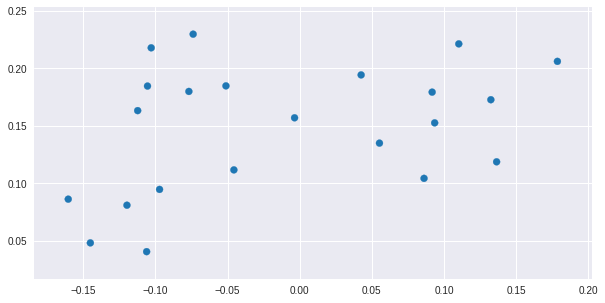

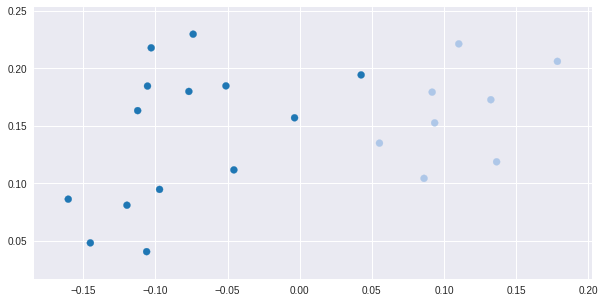

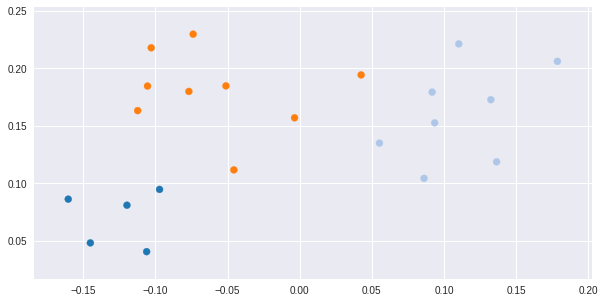

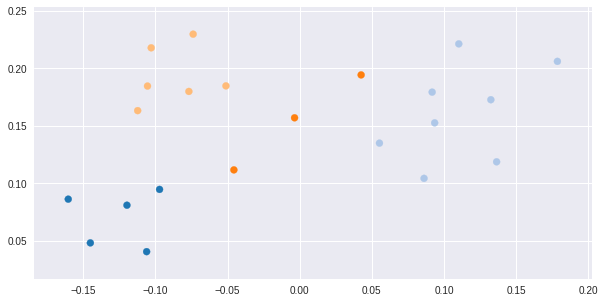

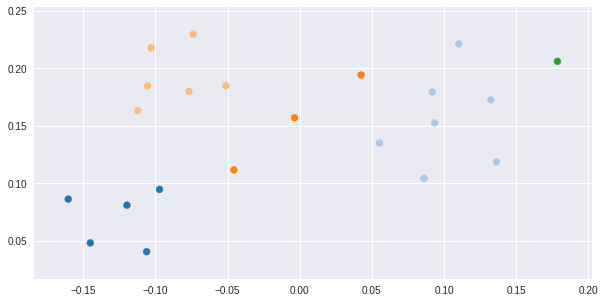

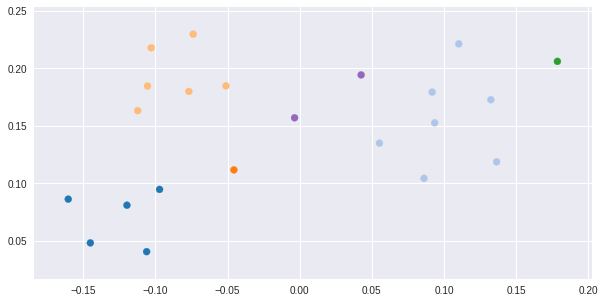

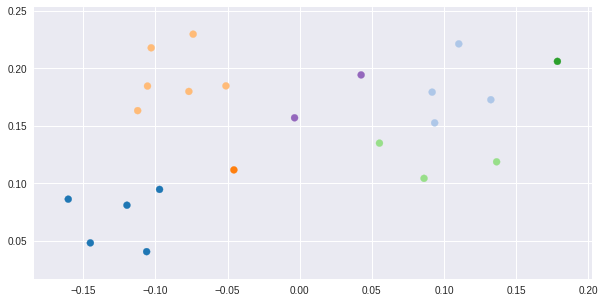

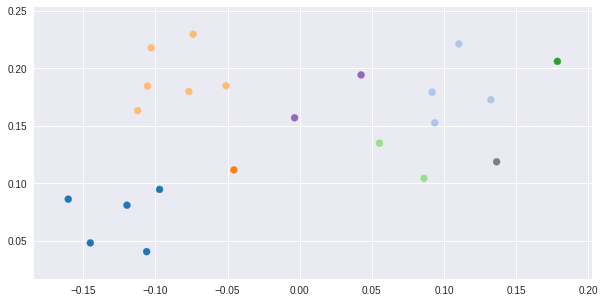

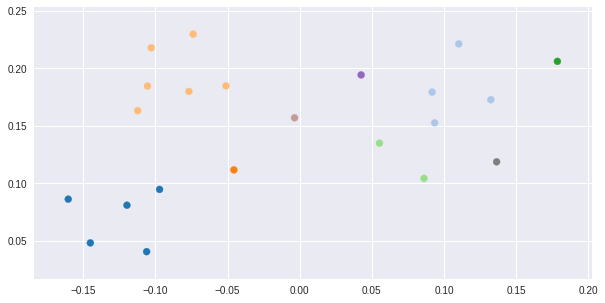

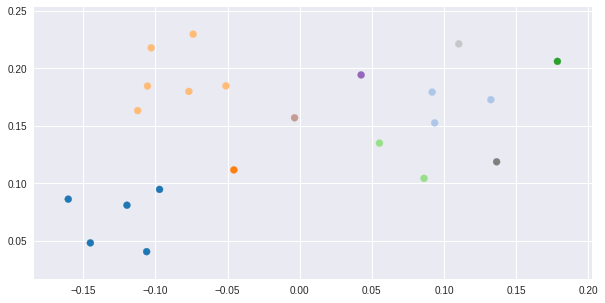

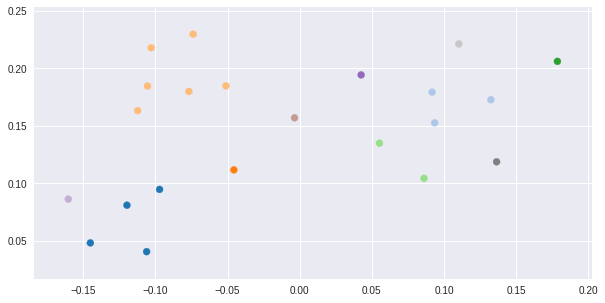

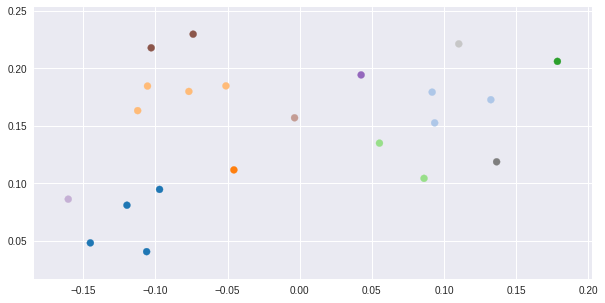

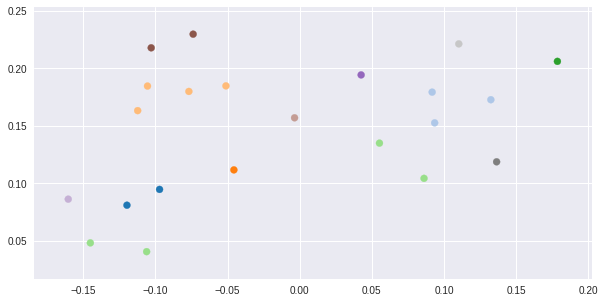

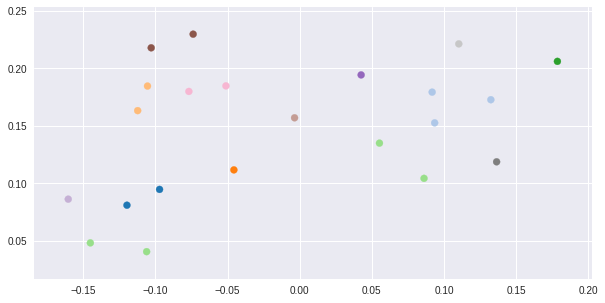

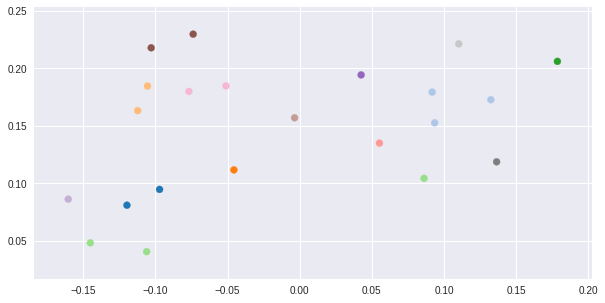

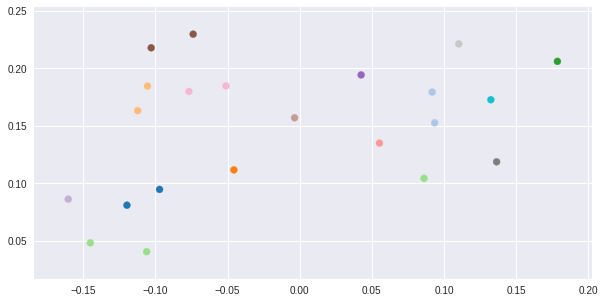

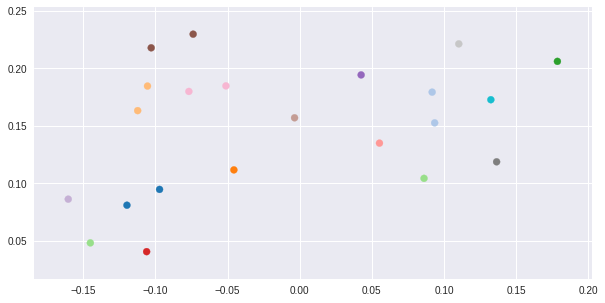

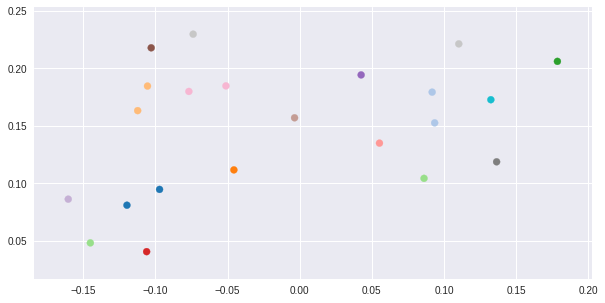

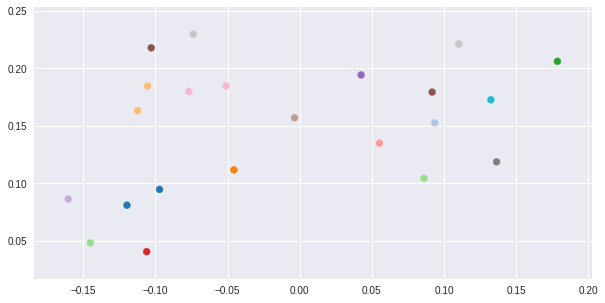

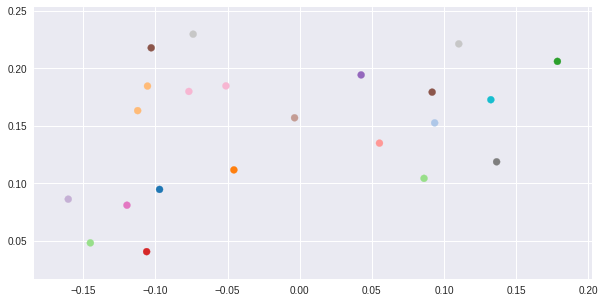

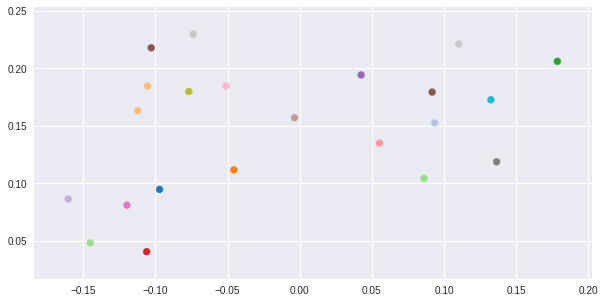

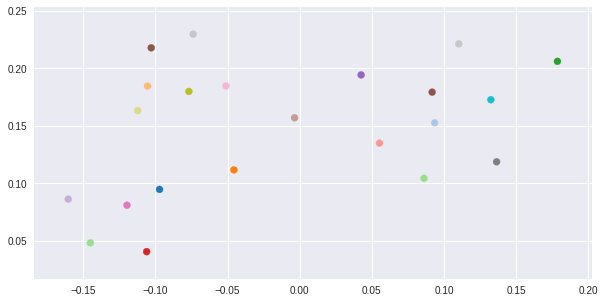

In [0]:

plot_particiones(Dx, mParticiones)



El clustering jerárquico devuelve un espectro de agrupamientos. Muchas veces, es necesario seleccionar una única partición. Dada la matriz mParticiones, esto equivalente a quedarse con una de las columnas. Si queremos seleccionar una partición donde hayan K clústeres, debemos seleccionar la columna K-1. Así, podemos calcular el valor de una métrica de evaluación cualquiera. En este caso, usamos las métricas de ancho de silueta y de Calinski Harabaz:


In [0]:
from sklearn.metrics import silhouette_score,calinski_harabaz_score

K = 4
partToEval = mParticiones[:,K-1]

print('La medida de Silueta con K =',K,'es',silhouette_score(Dx,partToEval)
print('La medida de Calinski Harabaz con K =',K,'es',calinski_harabaz_score(Dx, partToEval))

La medida de Silueta con K = 4 es 0.4408872869802952  (** ESTE ES EL RESULTADO A INCLUIR EN EL CAMPUS**)
La medida de Calinski Harabaz con K = 4 es 39.06472472659191



Podríamos incluso dibujar de manera sencilla la figura del codo recorriendo todas las columnas:


Text(0, 0.5, 'Medida de Calinski Harabaz')

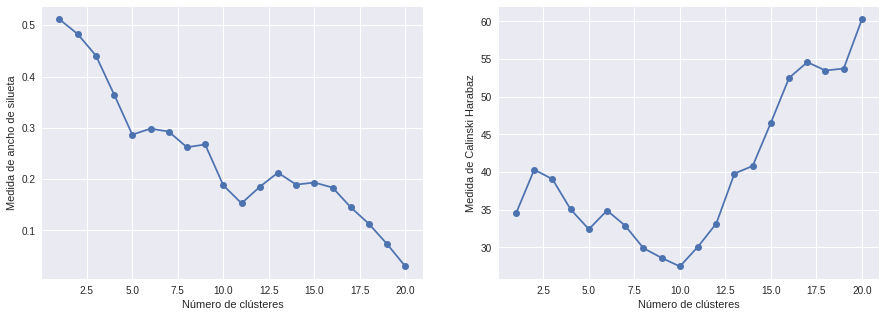

In [0]:
rsilueta = np.zeros(mParticiones.shape[1])
rch = np.zeros(mParticiones.shape[1])
for K in np.arange(1,mParticiones.shape[1]-1):
    rsilueta[K] = silhouette_score(Dx, mParticiones[:,K])
    rch[K] = calinski_harabaz_score(Dx, mParticiones[:,K])

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,mParticiones.shape[1]-1), rsilueta[np.arange(1,mParticiones.shape[1]-1)],
           linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot(np.arange(1,mParticiones.shape[1]-1), rch[np.arange(1,mParticiones.shape[1]-1)],
           linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de Calinski Harabaz")
